## Get all original audio sources

In [1]:
import pandas as pd

# Load the dataset
data = pd.read_csv('dataset_splits.csv')

# Assuming the dataset has a column named 'split' that indicates the data split
test_df = data[data['dataset'] == 'test']

# Reset the index and drop the 'dataset' column
test_df = test_df.reset_index(drop=True).drop(columns=['dataset'])

print(test_df.shape)
test_df.head()

(53, 2)


,file_path,class
0,wavfiles/Samba/Media-103505.wav,Samba
1,wavfiles/Waltz/Media-104702.wav,Waltz
2,wavfiles/Waltz/Media-104201.wav,Waltz
3,wavfiles/Waltz/Media-105104.wav,Waltz
4,wavfiles/ChaChaCha/Albums-Mambo_Kings-11.wav,ChaChaCha


In [2]:
import librosa
import soundfile as sf
import os

# Function to downsample audio
def downsample_audio(file_path, target_sr=16000):
    # Load audio file
    y, sr = librosa.load(file_path, sr=None)
    # Resample the audio to target sample rate
    y_resampled = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
    # Save the resampled audio to a new path
    new_path = file_path.replace('wavfiles', 'wavfiles_16k')
    if not os.path.exists(os.path.dirname(new_path)):
        os.makedirs(os.path.dirname(new_path))
    sf.write(new_path, y_resampled, target_sr)
    return new_path

# Apply downsampling to all audio files in the DataFrame
test_df['file_path'] = test_df['file_path'].apply(downsample_audio)


print(test_df.shape)
test_df.head()

(53, 2)


,file_path,class
0,wavfiles_16k/Samba/Media-103505.wav,Samba
1,wavfiles_16k/Waltz/Media-104702.wav,Waltz
2,wavfiles_16k/Waltz/Media-104201.wav,Waltz
3,wavfiles_16k/Waltz/Media-105104.wav,Waltz
4,wavfiles_16k/ChaChaCha/Albums-Mambo_Kings-11.wav,ChaChaCha


## Import music classification model

In [4]:
import tensorflow as tf


model = tf.saved_model.load('saved')


# Test the model
model(test_df.at[0,'file_path'])


{'predictions': <tf.Tensor: shape=(8,), dtype=float32, numpy=
 array([0.1034008 , 0.10320905, 0.10370582, 0.13361286, 0.24644685,
        0.10320815, 0.10320831, 0.10320818], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(), dtype=int64, numpy=4>,
 'class_names': <tf.Tensor: shape=(), dtype=string, numpy=b'Samba'>}

## Predict the class of each audio source

In [5]:
import pandas as pd

# Create a DataFrame to store wav file paths and their predicted classes
wav_files_df = pd.DataFrame(columns=['file_path', 'class', 'predictions'])

wav_files_df['file_path'] = test_df['file_path']
wav_files_df['class'] = test_df['class']
wav_files_df['predictions'] = wav_files_df['file_path'].apply(lambda x: model(x))


In [6]:
wav_files_df['pred_id']= wav_files_df['predictions'].apply(lambda x: x['class_ids'].numpy())
wav_files_df['pred_result']= wav_files_df['predictions'].apply(lambda x: x['class_names'].numpy().decode('utf-8'))
wav_files_df['probability']= wav_files_df['predictions'].apply(lambda x: x['predictions'].numpy())


print(wav_files_df.shape)
wav_files_df.head()

(53, 6)


,file_path,class,predictions,pred_id,pred_result,probability
0,wavfiles_16k/Samba/Media-103505.wav,Samba,"{'predictions': (tf.Tensor(0.103400804, shape=...",4,Samba,"[0.103400804, 0.10320905, 0.10370582, 0.133612..."
1,wavfiles_16k/Waltz/Media-104702.wav,Waltz,"{'predictions': (tf.Tensor(0.106073745, shape=...",7,Waltz,"[0.106073745, 0.106067, 0.106071495, 0.1235382..."
2,wavfiles_16k/Waltz/Media-104201.wav,Waltz,"{'predictions': (tf.Tensor(0.107379556, shape=...",7,Waltz,"[0.107379556, 0.10712371, 0.10719236, 0.115667..."
3,wavfiles_16k/Waltz/Media-105104.wav,Waltz,"{'predictions': (tf.Tensor(0.10638351, shape=(...",7,Waltz,"[0.10638351, 0.1063745, 0.10639926, 0.1148417,..."
4,wavfiles_16k/ChaChaCha/Albums-Mambo_Kings-11.wav,ChaChaCha,"{'predictions': (tf.Tensor(0.19541323, shape=(...",0,ChaChaCha,"[0.19541323, 0.10512047, 0.14400645, 0.1060244..."


In [7]:
wav_files_df.to_csv('original_source_predictions.csv')

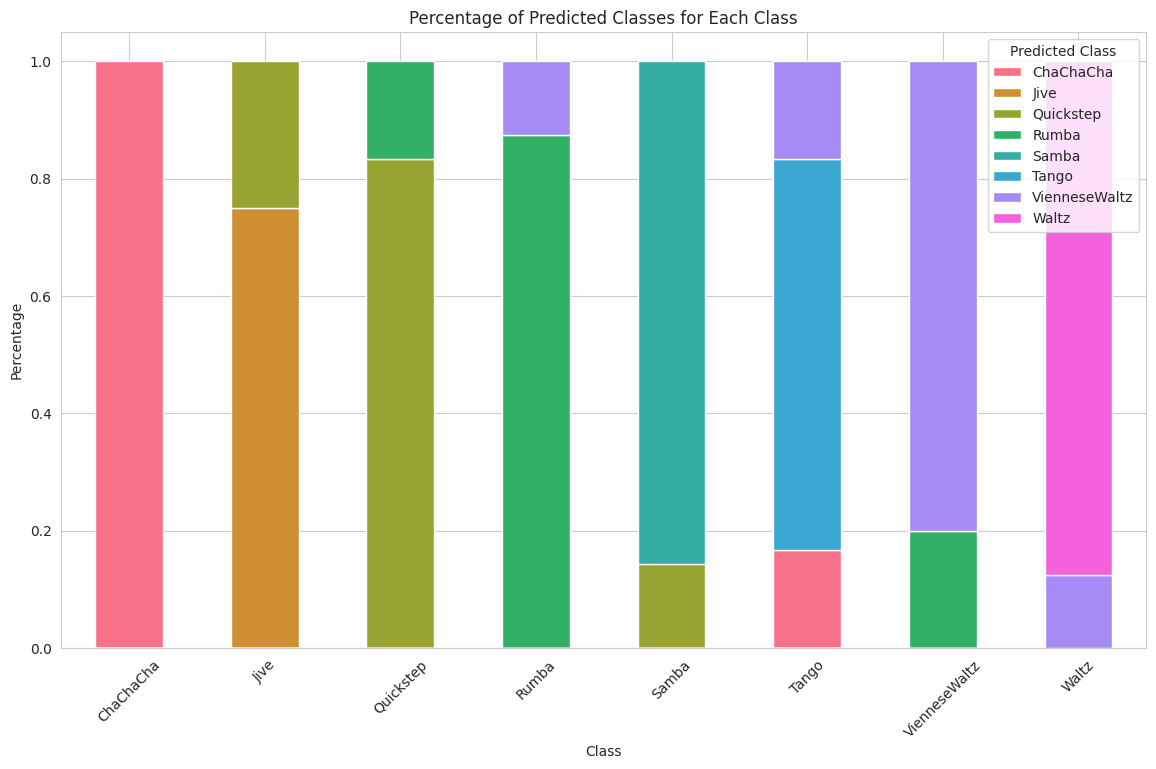

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

def plot_bar_chart_by_class(df):
    # Group by 'type' and then plot the count of 'y' values for each type
    grouped = df.groupby('class')['pred_result'].value_counts(normalize=True).unstack().fillna(0)
    colors = sns.color_palette("husl", len(grouped.columns))
    grouped.plot(kind='bar', figsize=(14, 8), stacked=True, color=colors)
    plt.title('Percentage of Predicted Classes for Each Class')
    plt.xlabel('Class')
    plt.ylabel('Percentage')
    plt.xticks(rotation=45)
    plt.legend(title='Predicted Class')
    plt.show()

# Call the function to plot the chart
plot_bar_chart_by_class(wav_files_df)




In [9]:
import pandas as pd


ori_df=pd.read_csv('original_source_predictions.csv')
aug_df=pd.read_csv('augmentation_features.csv')



## The model prediction in original audio source

In [10]:
ori_df.groupby('class')['pred_result'].value_counts(normalize=True).unstack().fillna(0)

pred_result,ChaChaCha,Jive,Quickstep,Rumba,Samba,Tango,VienneseWaltz,Waltz
class,,,,,,,,
ChaChaCha,1.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000
Jive,0.000000,0.75,0.250000,0.000000,0.000000,0.000000,0.000000,0.000
Quickstep,0.000000,0.00,0.833333,0.166667,0.000000,0.000000,0.000000,0.000
Rumba,0.000000,0.00,0.000000,0.875000,0.000000,0.000000,0.125000,0.000
Samba,0.000000,0.00,0.142857,0.000000,0.857143,0.000000,0.000000,0.000
Tango,0.166667,0.00,0.000000,0.000000,0.000000,0.666667,0.166667,0.000
VienneseWaltz,0.000000,0.00,0.000000,0.200000,0.000000,0.000000,0.800000,0.000
Waltz,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.125000,0.875


## The model prediction in augmented audio source



In [11]:
aug_df.groupby('type')['y'].value_counts(normalize=True).unstack().fillna(0)



y,ChaChaCha,Jive,Quickstep,Rumba,Samba,Tango,VienneseWaltz,Waltz
type,,,,,,,,
ChaChaCha,0.216667,0.006667,0.036667,0.00,0.100000,0.270000,0.200000,0.170000
Jive,0.000000,0.086667,0.176667,0.00,0.020000,0.306667,0.370000,0.040000
Quickstep,0.000000,0.010000,0.200000,0.00,0.000000,0.366667,0.406667,0.016667
Rumba,0.030000,0.000000,0.113333,0.03,0.000000,0.093333,0.270000,0.463333
Samba,0.000000,0.000000,0.266667,0.00,0.000000,0.300000,0.173333,0.260000
Tango,0.000000,0.000000,0.100000,0.00,0.016667,0.650000,0.216667,0.016667
VienneseWaltz,0.000000,0.000000,0.000000,0.00,0.000000,0.096667,0.683333,0.220000
Waltz,0.000000,0.000000,0.000000,0.00,0.000000,0.016667,0.046667,0.936667
